# Import Packages

In [54]:
## Generic packages that are on your operating system
import glob
import os
import time

## Additional required packages
import numpy as np
import joblib
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt


# Required definitions

In [341]:
files = glob.glob('datasets/IMERG*_Nairobi.zarr')
ds_IMERG = xr.open_mfdataset(files,engine="zarr")

latitude_IMERG = ds_IMERG.latitude.values
longitude_IMERG = ds_IMERG.longitude.values

box_left = longitude_IMERG-0.05
box_right = longitude_IMERG+0.05
box_down = latitude_IMERG-0.05
box_up = latitude_IMERG+0.05


def bounding_box(region,points,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up):

    """
    points: latitude, longitude
    x: longitude
    y: latitude
    """

    section_x = []
    section_y = []
    
    for x_min, x_max in zip(box_left,box_right):
        if region == 'J.K.I.A.':
            section_x.append(np.logical_and(points[1]<=x_max+0.01,points[1]>=x_min-0.01))
        else:
            section_x.append(np.logical_and(points[1]<=x_max,points[1]>=x_min))
            
    for y_min, y_max in zip(box_down,box_up):    
        section_y.append(np.logical_and(points[0]<=y_max,points[0]>=y_min))

    idx = np.squeeze(np.argwhere(np.logical_and(np.array(section_x),np.array(section_y))))

    return idx

In [342]:
def return_as_xarray(data, ds_ref, percentiles):
    
    dims = ['percentile','bin','time','region']
    coords = {
            'percentile': percentiles,
             'bin': ds_ref.bin.values,
             'time':ds_ref.time.values,
             'region':ds_ref.region.values
         }
    da = xr.DataArray(data=data,
                         dims=dims,
                         coords=coords,
                      )
    return da

def MultiClassEncoder(data, n_classes=4,ex_prob=False):

    data_encoded = [xr.where(data==cl,1,0).expand_dims(dim={"bin": [cl]}) for cl in range(n_classes)]
    return xr.concat(data_encoded, dim="bin")

def get_bins(data, bins=[5,20,50], OBS=False):

    if not isinstance(data,xr.core.dataarray.DataArray):
        data = data.to_dataarray()
    dims = ['time','region']
    coords = {
         'time':data.time.values,
         'region':data.coords['variable'].values,
     }
    binned_data = np.searchsorted(bins, data).T
    binned_data = xr.DataArray(data=binned_data,
                         dims=dims,
                         coords=coords,
                      )
    return binned_data

    
def get_warning(binned_data, allowed_risk=None):
    
    if allowed_risk is None:
        Warnings = MultiClassEncoder(binned_data)
        return Warnings
    
    else:

        ex_prob = binned_data
        Warnings = np.zeros([len(allowed_risk),len(ex_prob.bin.values),
                             len(ex_prob.time.values),1])
        
        i=0
        for risk in allowed_risk:
            Warnings[i,ex_prob>=risk] = 1
            i+=1

        return return_as_xarray(Warnings, ex_prob, allowed_risk)

def get_hits_misses_far(Warnings_obs, Warnings):
    
    ## Only interested where both are 1
    Hits = Warnings_obs*Warnings

    ## Only interested for difference = 1
    False_alarms = xr.where((Warnings-Warnings_obs)<=0,0,(Warnings-Warnings_obs))

    ## Only interested for difference = -1
    Misses = xr.where((Warnings_obs-Warnings)<=0,0,(Warnings_obs-Warnings))

    ## Only interested where both are 0
    True_negatives =  np.abs(Warnings-1)*np.abs(Warnings_obs-1)

   
    Hits = Hits.expand_dims({'metric':['Hits']},axis=0)
    Misses = Misses.expand_dims({'metric':['Misses']},axis=0)
    False_alarms = False_alarms.expand_dims({'metric':['False_alarms']},axis=0)
    True_negatives = True_negatives.expand_dims({'metric':['True_negatives']},axis=0)


    return xr.concat([Hits,False_alarms,True_negatives,Misses], 'metric').to_dataset('metric')

        
            


# Load in data

In [343]:
files = glob.glob('datasets/cGAN_50_202*_Nairobi.zarr')
ds_cGAN_50 = []
for file in files:
    ds_temp = xr.open_dataset(file,engine="zarr")
    if type(ds_temp['time'].values[0]) == np.float32:
        ds_temp['time'] = (ds_temp['time'].astype('datetime64[ns]')+np.timedelta64(1,'h')).astype('datetime64[D]').astype('datetime64[ns]')
    ds_cGAN_50.append(ds_temp) 
ds_cGAN_50 = xr.concat(ds_cGAN_50, 'time').sortby('time')
ds_cGAN_50 = ds_cGAN_50.sel(time=ds_cGAN_50.time.dt.year.isin([2023,2024]))

files = glob.glob('datasets/cGAN_202*_Nairobi.zarr')
ds_cGAN = []
for file in files:
    ds_temp = xr.open_dataset(file,engine="zarr")
    if type(ds_temp['time'].values[0]) == np.float32:
        ds_temp['time'] = (ds_temp['time'].astype('datetime64[ns]')+np.timedelta64(1,'h')).astype('datetime64[D]').astype('datetime64[ns]')
    ds_cGAN.append(ds_temp) 
ds_cGAN = xr.concat(ds_cGAN, 'time').sortby('time')
ds_cGAN = ds_cGAN.sel(time=ds_cGAN.time.dt.year.isin([2023,2024]))

files = glob.glob('datasets/IFS_202*_Nairobi.zarr')
ds_IFS = []
for file in files:
    ds_IFS.append(xr.open_zarr(file).drop_duplicates('time',keep='last'))

ds_IFS = xr.concat(ds_IFS,'time').sortby('time')
ds_IFS = ds_IFS.sel(time=ds_IFS.time.dt.year.isin([2023,2024]))

meta = pd.read_excel('SEWAA-data.xlsx',sheet_name='Gridded',index_col=0,nrows=2)
data = pd.read_excel('SEWAA-data.xlsx',sheet_name='Gridded',index_col=0,skiprows=[1,2])

ds = data.to_xarray().rename({'ID':'time'})

# Not sure if this is the best way but it works
ds['time'] = np.array([t[:4]+'-'+t[4:6]+'-'+t[-2:] for t in ds['time'].values.astype(str)],dtype='datetime64[ns]')
ds = ds.sel(time=ds.time.dt.year.isin([2023,2024]))


## Load observational point data

In [344]:
def parser(vals):
    vals_temp = np.zeros_like(vals.flatten())
    for i, val in enumerate(vals.flatten()):
        if type(val) is str:
            try:
                vals_temp[i] = val.replace('..','.').replace(" ","").astype(np.float64)
            except:
                vals_temp[i] = 0
            
        else:
            vals_temp[i] = val
    
    return vals_temp.astype(np.float64)
    
file_path='SEWAA-data.xlsx'
sheets = pd.ExcelFile(file_path).sheet_names

meta = []
ds = []
for sheet in sheets[1:-1]:

    df_meta = pd.read_excel('SEWAA-data.xlsx',sheet_name=sheet)
    columns = df_meta.columns
    region = np.unique(df_meta['Station_Name'])
    region = [region[0].split(" ")[0]]
    try:
        lat = np.unique(df_meta['lat'])
        lon = np.unique(df_meta['lon'])
    except:
        lat = np.unique(df_meta['Lat'])
        lon = np.unique(df_meta['Lon'])
    meta.append(xr.DataArray(data=np.hstack((lon,lat))[None,:],
                            dims = ['region','ID'],
                            coords = {'region':region,
                                     'ID':['lon','lat']}))
    year_idx = np.squeeze(np.argwhere(columns=='Year'))
    use_cols = np.arange(33)+year_idx
    df = pd.read_excel('SEWAA-data.xlsx',sheet_name=sheet,
                       index_col=[0,1],usecols=use_cols)
    data = []
    times = []
    for year,month in df.index.values:
        if month!=12:
            times.append(np.arange(f'{year}-{month:02}-01',f'{year}-{month+1:02}-01',
                                   np.timedelta64(1,'D'),dtype='datetime64[ns]'))
        else:
            times.append(np.arange(f'{year}-{month:02}-01',f'{year+1}-01-01',
                                   np.timedelta64(1,'D'),dtype='datetime64[ns]'))

        no_of_days = len(times[-1])

        data.append(parser(df.loc[[(year,month)]].values).reshape(-1,1)[:no_of_days])


    times = np.hstack((times))
    data = np.vstack((data))

    ds.append(xr.DataArray(data=data,
                           dims = ['time','region'],
                           coords = {
                               'time':times,
                               'region':region,
                           }))

meta = xr.concat(meta,'region').to_dataset('region')
ds = xr.concat(ds,'region').to_dataset('region')


In [307]:
ds

<xarray.Dataset> Size: 140kB
Dimensions:    (time: 2496)
Coordinates:
  * time       (time) datetime64[ns] 20kB 2018-01-01 2018-01-02 ... 2024-10-31
Data variables:
    KABETE     (time) float64 20kB 1.0 0.0 20.0 5.0 0.2 ... 0.4 1.7 0.0 0.0 20.5
    EASTLEIGH  (time) float64 20kB 0.0 1.4 4.1 0.6 0.0 ... 0.0 0.0 0.0 0.0 0.0
    J.K.I.A.   (time) float64 20kB 0.0 7.5 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    DAGORETTI  (time) float64 20kB 0.0 0.0 9.1 2.8 0.0 ... 0.0 0.0 0.0 0.0 0.0
    NGONG      (time) float64 20kB 0.0 26.9 0.0 2.1 4.3 ... 0.0 0.0 0.0 0.0 0.0
    WILSON     (time) float64 20kB 0.0 0.0 9.9 0.9 0.0 ... 0.0 0.0 0.0 0.0 0.0

## Load KMD WRF data

In [345]:
import warnings
warnings.filterwarnings("ignore")

files = glob.glob('wrf_data/March/*.nc')
files+= glob.glob('wrf_data/April/*.nc')
files+= glob.glob('wrf_data/May/*.nc')

ds_WRF = []
for file in files:
    ds_temp = xr.open_dataset(file)
    data_temp = np.squeeze(ds_temp.rainnc.sum('time').values)+np.squeeze(ds_temp.rainc.sum('time').values)
    ds_WRF.append(xr.DataArray(data = data_temp,
                               dims = ['lat','lon'],
                               coords = {'lat':ds_temp.lat.values,
                                        'lon':ds_temp.lon.values}
                              ).expand_dims({'time':[ds_temp.time.values[0].astype('datetime64[D]').astype('datetime64[ns]')]},
                                           axis=0))

ds_WRF = xr.concat(ds_WRF,'time').sortby('time').sel({'lat':longitude_IMERG,
                                                      'lon':latitude_IMERG},method='nearest')
                           
    

In [295]:
ds_temp

<xarray.Dataset> Size: 9MB
Dimensions:  (time: 8, lon: 291, lat: 328, lev: 1)
Coordinates:
  * time     (time) datetime64[ns] 64B 2024-05-31 ... 2024-05-31T21:00:00
  * lon      (lon) float64 2kB 32.67 32.71 32.74 32.78 ... 43.03 43.07 43.11
  * lat      (lat) float64 3kB -5.554 -5.518 -5.482 -5.446 ... 6.119 6.155 6.19
  * lev      (lev) float64 8B 1e+03
Data variables:
    rainc    (time, lev, lat, lon) float32 3MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    rainnc   (time, lev, lat, lon) float32 3MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    t2       (time, lev, lat, lon) float32 3MB ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9rc1 (https://mpimet.mpg...
    Conventions:  CF-1.6
    history:      Thu Aug 29 16:31:57 2024: cdo -O splitday total_DEACCUM.nc ...
    CDO:          Climate Data Operators version 1.9.9rc1 (https://mpimet.mpg...

In [37]:
latitude_WRF = ds_WRF.lon.values ## THE LAT/LON VALUES IN DS_IMERG ARE SWITCHED AROUND
longitude_WRF = ds_WRF.lat.values ## STICK TO THIS CONVENTION FOR NOW

box_left_WRF = longitude_WRF-0.05
box_right_WRF = longitude_WRF+0.05
box_down_WRF = latitude_WRF-0.05
box_up_WRF = latitude_WRF+0.05

## Prepare validation data

In [346]:
val_data_x = {}

val_data_x['cGAN'] = ds_cGAN
val_data_x['cGAN_50'] = ds_cGAN_50
val_data_x['IFS'] = ds_IFS
val_data_x['WRF'] = ds_WRF

val_valid_times = np.intersect1d(val_data_x['IFS'].time.values + np.timedelta64(1,'D'),
                                   ds.time.values)
val_valid_times = np.intersect1d(val_data_x['WRF'].time.values,
                                   val_valid_times)
val_data_x['cGAN'] = val_data_x['cGAN'].sel({'time':val_valid_times - np.timedelta64(1,'D')})
val_data_x['cGAN_50'] = val_data_x['cGAN_50'].sel({'time':val_valid_times - np.timedelta64(1,'D')})
val_data_x['IFS'] = val_data_x['IFS'].sel({'time':val_valid_times - np.timedelta64(1,'D')})
val_data_x['WRF'] = val_data_x['WRF'].drop_duplicates('time',keep='first').sel({'time':val_valid_times})

val_data_y = ds.sel({'time':val_valid_times})


# Get logistic regression probabilities

In [347]:
thresholds = [5,20,40]
hits_misses_far = {}
predicted_probabilities = {}
for model in ['cGAN','IFS','cGAN_50','WRF']:
    hits_misses_far[model] = {}
    predicted_probabilities[model] = []

    for region in ['KABETE','EASTLEIGH','J.K.I.A.','WILSON','DAGORETTI']:
        val_data_y_region = val_data_y[region].values
        
        if model != 'WRF': 
            idx_region =  bounding_box(region,meta[region].values,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up)
            val_data_x_region = val_data_x[model].isel({'latlon':idx_region}).Nairobi.values
        
            if val_data_x_region.shape[1]==1000:
                val_data_x_region = np.percentile(val_data_x_region,np.linspace(1,100,50),axis=1,method='weibull').T
            
            logreg = joblib.load(f'models/gridsearchresults_1-day_fcst.pkl')
            
            predicted_probabilities[model].append(xr.DataArray(data=logreg[model][40].predict_proba(val_data_x_region).T[:,:,None],
                                                   dims = ['bin','time','region'],
                                                   coords = {
                                                       'time':val_data_y.time.values,
                                                       'bin':np.arange(2),
                                                       'region':[region]
                                                   }
                                                  ))
            warnings = get_warning(predicted_probabilities[model][-1], [0.1,0.2,0.3,0.4,0.5,0.6])
        else:
            idx_region =  bounding_box(region,meta[region].values,min_x=box_left_WRF,
                                        max_x=box_right_WRF,min_y=box_down_WRF,max_y=box_up_WRF)
            val_data_x_region = val_data_x[model].stack(latlon=('lon','lat')).isel({'latlon':idx_region})

            warnings = get_warning(get_bins(val_data_x_region.expand_dims({'variable':[region]}\
                                                                         ).assign_coords(coords={'variable':[region]}),bins=thresholds))
        ds_bin = get_bins(ds,bins=thresholds)
        warnings_obs = get_warning(ds_bin)
 
        hits_misses_far[model][region] = get_hits_misses_far(warnings_obs, warnings)
    if model!='WRF':
        predicted_probabilities[model] = xr.concat(predicted_probabilities[model],'region')    


Text(0.5, 1.0, 'IFS, KABETE, bin no.:1')

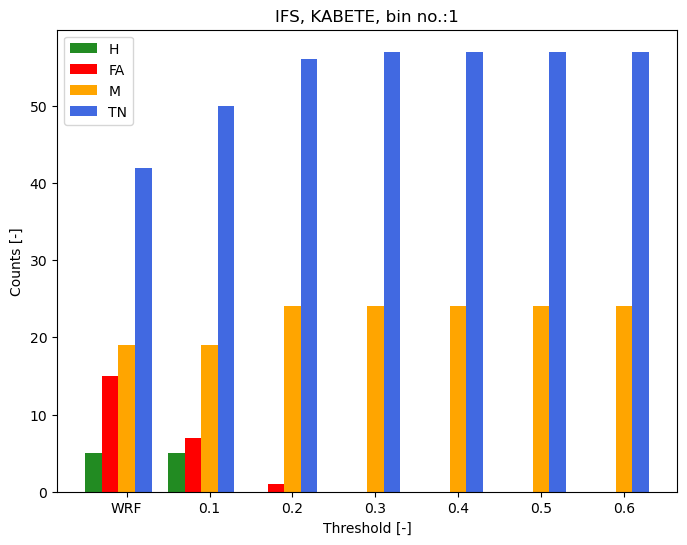

In [348]:
model = "IFS"
region = "KABETE"
figure = plt.figure(figsize=(8,6))
ax = figure.add_subplot(1,1,1)
bin_to_plot = 1
colours = ['forestgreen','red','orange','royalblue']

i_x = 0
x_values = [i_x-0.4,i_x-0.2,i_x,i_x+0.2]
heights = [hits_misses_far['WRF'][region].Hits.isel({'bin':bin_to_plot}).sum(),
           hits_misses_far['WRF'][region].False_alarms.isel({'bin':bin_to_plot}).sum(),
           hits_misses_far['WRF'][region].Misses.isel({'bin':bin_to_plot}).sum(),
           hits_misses_far['WRF'][region].True_negatives.isel({'bin':bin_to_plot}).sum()]
ax.bar(x_values,heights,width=0.2,color=colours,label=['H','FA','M','TN'])

xlabels = ['WRF',]
xlabels+=list(hits_misses_far[model][region].percentile.values.astype('str'))

i_x+=1
for perc in hits_misses_far[model][region].percentile.values:

    x_values = [i_x-0.4,i_x-0.2,i_x,i_x+0.2]
    heights = [hits_misses_far[model][region].Hits.isel({'percentile':i_x-1,'bin':bin_to_plot}).sum(),
               hits_misses_far[model][region].False_alarms.isel({'percentile':i_x-1,'bin':bin_to_plot}).sum(),
               hits_misses_far[model][region].Misses.isel({'percentile':i_x-1,'bin':bin_to_plot}).sum(),
               hits_misses_far[model][region].True_negatives.isel({'percentile':i_x-1,'bin':bin_to_plot}).sum()]

    ax.bar(x_values,heights,width=0.2,color=colours)
    i_x+=1

ax.set_xticks(np.arange(i_x))
ax.set_xticklabels(xlabels)
plt.legend()
ax.set_xlabel('Threshold [-]')
ax.set_ylabel('Counts [-]')
ax.set_title(f'{model}, {region}, bin no.:{bin_to_plot}')

PathPatch6((-0.275, 7.85515) ...)
PathPatch6((0.725, 1.74309) ...)
PathPatch6((1.725, 2.09533) ...)
PathPatch6((2.725, 3.09693) ...)
PathPatch6((3.725, 1.03517) ...)
PathPatch6((4.725, 2.14558) ...)
PathPatch6((5.725, 1.85813) ...)
PathPatch6((6.725, 0.938824) ...)
PathPatch6((7.725, 0.846263) ...)
PathPatch6((8.725, 1.4024) ...)
PathPatch6((9.725, 2.513) ...)
PathPatch6((10.725, 6.52931) ...)
PathPatch6((11.725, 8.0746) ...)
PathPatch6((12.725, 5.63299) ...)
PathPatch6((13.725, 9.97359) ...)
PathPatch6((14.725, 6.67521) ...)
PathPatch6((15.725, 9.75) ...)
PathPatch6((16.725, 7.88251) ...)
PathPatch6((17.725, 4.07436) ...)
PathPatch6((18.725, 6.21724) ...)
PathPatch6((0.025, 8.35054) ...)
PathPatch6((1.025, 1.43816) ...)
PathPatch6((2.025, 1.73136) ...)
PathPatch6((3.025, 3.23163) ...)
PathPatch6((4.025, 2.9752) ...)
PathPatch6((5.025, 5.58681) ...)
PathPatch6((6.025, 3.77315) ...)
PathPatch6((7.025, 2.22769) ...)
PathPatch6((8.025, 2.89695) ...)
PathPatch6((9.025, 3.82943) ...)
PathPa

(0.0, 152.0)

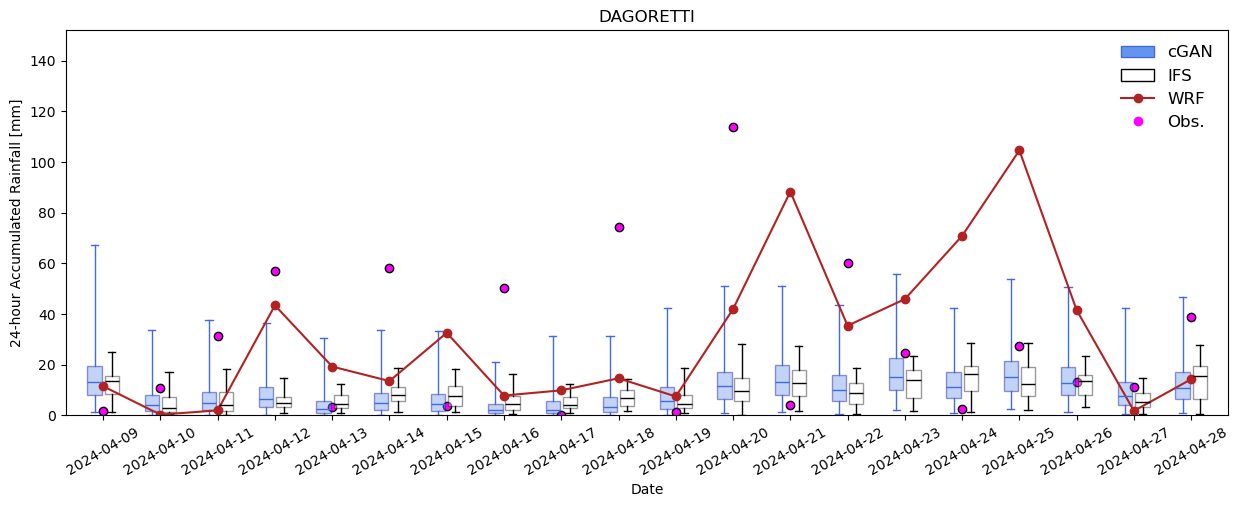

In [349]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

region = 'DAGORETTI'

times = np.arange('2024-04-09','2024-04-29',np.timedelta64(1,'D'),dtype='datetime64[ns]')

idx_region =  bounding_box(region,meta[region].values,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up)
idx_region_WRF = bounding_box(region,meta[region].values,min_x=box_left_WRF,
                                        max_x=box_right_WRF,min_y=box_down_WRF,max_y=box_up_WRF)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)

val_data_x_region = val_data_x['cGAN'].sel({'time':times-np.timedelta64(1,'D')}).isel({'latlon':idx_region}).Nairobi.clip(0,150).values
#print(val_data_x_region.max())
boxes = ax.boxplot(np.moveaxis(val_data_x_region,-1,1).reshape(-1,1000).T, positions=np.arange(20)-0.15,whis=[0.5,99.5],showfliers=False,showcaps=True,patch_artist=True,widths = 0.25,)

plt.setp(boxes['boxes'],color='darkblue',linewidth=1)
    
for i_patch,patch in enumerate(boxes['boxes']):
    print(patch)                    
    patch.set(facecolor='cornflowerblue',alpha=0.4)
    
plt.setp(boxes['medians'],color='royalblue',linewidth=1)
plt.setp(boxes['whiskers'],color='royalblue',linewidth=1)
plt.setp(boxes['caps'],color='royalblue',linewidth=1)


val_data_x_region = val_data_x['IFS'].sel({'time':times-np.timedelta64(1,'D')}).isel({'latlon':idx_region}).Nairobi.values
boxes = ax.boxplot(val_data_x_region.reshape(-1,50).T, positions=np.arange(20)+0.15,whis=[0.5,99.5],showfliers=False,showcaps=True,patch_artist=True,widths = 0.25,)

plt.setp(boxes['boxes'],color='black',linewidth=1)
    
for i_patch,patch in enumerate(boxes['boxes']):
    print(patch)                    
    patch.set(facecolor='white',alpha=0.4)
    
plt.setp(boxes['medians'],color='black',linewidth=1)
plt.setp(boxes['whiskers'],color='black',linewidth=1)
plt.setp(boxes['caps'],color='black',linewidth=1)

val_data_x_region  = val_data_x['WRF'].sel({'time':times}).stack(latlon=('lon','lat')).isel({'latlon':idx_region_WRF}).values
ax.plot(np.arange(20), val_data_x_region.reshape(-1), 'o-',color='firebrick')

ax.scatter(np.arange(20), np.squeeze(val_data_y[region].sel({'time':times}).values.reshape(-1)), facecolor='magenta', edgecolor='black')

#IMERG_y = ds_IMERG.sel({'time':times-np.timedelta64(1,'D')}).isel({'latlon':idx_region}).Nairobi.values
#ax.scatter(np.arange(20), IMERG_y.reshape(-1), facecolor='forestgreen', edgecolor='black')

ax.set_ylabel('24-hour Accumulated Rainfall [mm]')
ax.set_xlabel('Date')
ax.set_title(region)

plt.legend([Patch(facecolor='cornflowerblue',edgecolor='royalblue'),
       Patch(facecolor='white',edgecolor='black'),
            Line2D([0], [0], marker='o', color='firebrick'),
            Line2D([0], [0], marker='o', color='magenta', linewidth=0),
            #Line2D([0], [0], marker='o', color='forestgreen', linewidth=0)
           ],['cGAN','IFS','WRF','Obs.'],frameon=False,fontsize=12)

ax.set_xticks(np.arange(20))
ax.set_xticklabels(times.astype('datetime64[D]'), rotation=30)
ax.set_ylim(0,152)

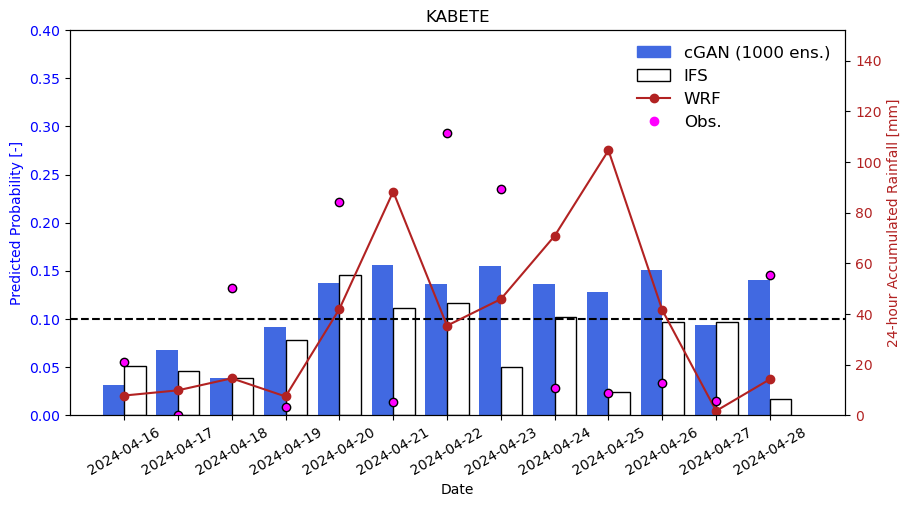

In [350]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

region = 'KABETE'

times = np.arange('2024-04-16','2024-04-29',np.timedelta64(1,'D'),dtype='datetime64[ns]')

idx_region =  bounding_box(region,meta[region].values,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up)
idx_region_WRF = bounding_box(region,meta[region].values,min_x=box_left_WRF,
                                        max_x=box_right_WRF,min_y=box_down_WRF,max_y=box_up_WRF)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax1 = ax.twinx()


ax.bar(np.arange(13)-0.2,predicted_probabilities['cGAN'].sel({'time':times,
                                                             'bin':1,'region':region}).values,width=0.4,color='royalblue',zorder=0.1)
#ax.bar(np.arange(19),predicted_probabilities['cGAN_50'].sel({'time':times,
#                                                             'bin':1,'region':region}).values,width=0.3,color='red',zorder=0.1)
ax.bar(np.arange(13)+0.2,predicted_probabilities['IFS'].sel({'time':times,
                                                             'bin':1,'region':region}).values,width=0.4,color='white',edgecolor='black',zorder=0.1)

val_data_x_region  = val_data_x['WRF'].sel({'time':times}).stack(latlon=('lon','lat')).isel({'latlon':idx_region_WRF}).values
ax1.plot(np.arange(13), val_data_x_region.reshape(-1), 'o-',color='firebrick',zorder=1)

ax1.scatter(np.arange(13), np.squeeze(val_data_y[region].sel({'time':times}).values.reshape(-1)),
           facecolor='magenta', edgecolor='black',zorder=1)

#IMERG_y = ds_IMERG.sel({'time':times-np.timedelta64(1,'D')}).isel({'latlon':idx_region}).Nairobi.values
#ax.scatter(np.arange(20), IMERG_y.reshape(-1), facecolor='forestgreen', edgecolor='black')

ax1.set_ylabel('24-hour Accumulated Rainfall [mm]',color='firebrick')
ax.set_ylabel('Predicted Probability [-]', color='blue')
ax.set_xlabel('Date')
ax.set_title(region)

plt.legend([Patch(facecolor='royalblue',edgecolor='royalblue'),
            #Patch(facecolor='red',edgecolor='red'),
       Patch(facecolor='white',edgecolor='black'),
            Line2D([0], [0], marker='o', color='firebrick'),
            Line2D([0], [0], marker='o', color='magenta', linewidth=0),
            #Line2D([0], [0], marker='o', color='forestgreen', linewidth=0)
           ],['cGAN (1000 ens.)','IFS','WRF','Obs.'],frameon=False,fontsize=12)

ax.set_xticks(np.arange(13))
ax.hlines(0.1,-1,20.2,'k',linestyle='dashed')
ax.set_xlim(-1,13.4)
ax.set_xticklabels(times.astype('datetime64[D]'), rotation=30)
ax1.set_ylim(0,152)
ax.set_ylim(0,0.4)
ax.tick_params(axis='y', labelcolor='blue')
ax1.tick_params(axis='y', labelcolor='firebrick')
